In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arrow
import datetime
import xarray as xr
import os
import cmocean.cm as cm
import matplotlib.cm as cma
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
import matplotlib.dates as mpl_dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import datetime as dt 
from matplotlib.patches import Rectangle
from IPython.display import Image, display
import pandas as pd
from salishsea_tools import viz_tools, places, visualisations

### Functions

In [2]:
variables = ['final_salt','final_transp','final_lon','final_lat','final_depth','final_section','final_z','final_temp','init_lon','init_z','init_salt','init_temp','init_transp','final_age','final_dens','init_dens','init_lat']

#Function to extract data from 1 section
def get_secdata(datafile,sectionnum):
    
    variables = ['final_salt','final_transp','final_lon','final_lat','final_depth','final_section','final_z','final_temp','init_lon','init_z','init_salt','init_temp','init_transp','final_age','final_dens','init_dens','init_lat']
    
    dict_var = {}
    
    idx = np.where(datafile['final_section']==sectionnum)
    
    for var in variables:
        if var == 'final_age':
            agetd = datafile[var].values
            agehr = agetd.astype('float64')/(10**9*3600)
            age = agehr[idx]
            dict_var[var] = xr.DataArray(age)
        else:
            data_sec = datafile[var]
            dict_var[var] = data_sec[idx]
        
    
    return dict_var      

def draw_patches(fmask, ll, ul, u_lons, w_depths,m2lon):
    topo = []
    for i in range(ll, ul):
        for j in range(39):
            if fmask[j, i] == 0:
                try:
                    rect = Rectangle((u_lons[i]/m2lon, w_depths[j+1]), u_lons[i+1]/m2lon-u_lons[i]/m2lon, w_depths[j+2]-w_depths[j+1])
                    topo.append(rect)
                except:
                    pass

    pc = PatchCollection(topo, facecolors='lightgray', edgecolors='none')
    return(pc)


def plotTS(axn,var,lonsec,zsec,varsec,lonW,lonE,latgridi,depi,time,title,cblabel,ylabel,vmin=None,vmax=None):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    arrw,xe,ye,im = axn.hist2d(lonsec/m2lon,df(zsec)[0],weights=varsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    arrnw,xe2,ye2,im2 = axn.hist2d(lonsec/m2lon,df(zsec)[0],cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    
    arr3 = arrw/arrnw
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axn.pcolormesh(X,Y,arr3.T,vmin=vmin,vmax=vmax)
    axn.set_xlabel('Longitude (°E)')
    axn.set_title(title)
    axn.invert_yaxis()
    axn.set_xticks(np.linspace(f_lons[lonW]/m2lon,f_lons[lonE-1]/m2lon,2))
    axn.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW],f_lons[lonE-1],2)])
    
    if cblabel == True:
        cb = fig.colorbar(im,ax=axn)
        
        if var == 'temp':
            cb.set_label('Temperature (°C)')
        if var == 'sal':
            cb.set_label('Salinity (g/kg)')
            
    if ylabel == True:
        axn.set_ylabel('Depth (m)')
    else:
        axn.set_yticks([])
        
def get_datat(datafile,section, starttime, endtime):
    final_section = datafile.final_section
    final_transport = datafile.final_transp
    transports = np.sum(np.where(final_section == section, final_transport, 0)) 
    return transports/(endtime-starttime+1)

### Import data

In [3]:
data = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
df = interp.interp1d(mesh.z,mesh.gdepw_1d) # Interpolate to get same binning scheme as SalishSeaCast

In [4]:
#Importing data and calculating section transport 
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# files = ['forpr_ros3','forpr_haro3','forvs_haro3']
files = ['forpr_sjc3','forgulf_sjc3','forvs_sjc3','foradm_sjc3','forpr_ros3','forgulf_ros3','forvs_ros3','foradm_ros3',
         'forpr_haro3','forgulf_haro3','forvs_haro3','foradm_haro32'] # Update config for foradm_haro
namen = ['datafvs']

starttime = 1
endtime = 24
sectionnum = [0,1,2,3,4,5,6,7,8]

date = dt.datetime(2018,1,1)
enddate = dt.datetime(2018,12,31)

dates = []
datelist_vs = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_vs.append(date)
    date+=dt.timedelta(days=1)
     
dicts = {}

for i,file in enumerate(files):
    dict_i = {}
    
    for date in dates:
        name = '/ocean/cstang/MOAD/analysis-camryn/Ariane/' + file + '/' + date + '_s1t50/ariane_positions_quantitative.nc'
        
        if os.path.isfile(name):
            dict_i[date] = xr.open_dataset(name)
        
    dicts[file] = dict_i
    
dict_sectiontransp = {}

for file in files:
    st_dict = {}
    for section in sectionnum:
        if section not in st_dict:
            st_dict[section] = []
            
        for date in dates:
            try:
                st_dict[section].append(get_datat(dicts[file][date],section,starttime,endtime))
            except:
                print(date)
                pass 
        dict_sectiontransp[file] = st_dict


28may18
28may18
28may18
28may18
28may18
28may18
28may18
28may18
28may18


In [5]:
prtovs_sjc_365 = np.insert(dict_sectiontransp['forpr_sjc3'][5], 147, np.nan)
prtoadm_sjc_365 = np.insert(dict_sectiontransp['forpr_sjc3'][2], 147, np.nan)
prtogulf_sjc_365 = np.insert(dict_sectiontransp['forpr_sjc3'][7], 147, np.nan)

#forpr_sjc
prtovs_sjc = pd.DataFrame({'Transport':prtovs_sjc_365},index=datelist_vs)
prtoadm_sjc = pd.DataFrame({'Transport':prtoadm_sjc_365},index=datelist_vs)
prtogulf_sjc = pd.DataFrame({'Transport':prtogulf_sjc_365},index=datelist_vs)

#forpr_haro
prtovs_haro = pd.DataFrame({'Transport':dict_sectiontransp['forpr_haro3'][6]},index=datelist_vs)
prtoadm_haro = pd.DataFrame({'Transport':dict_sectiontransp['forpr_haro3'][2]},index=datelist_vs)
prtogulf_haro = pd.DataFrame({'Transport':dict_sectiontransp['forpr_haro3'][7]},index=datelist_vs)

#forpr_ros
prtovs_ros = pd.DataFrame({'Transport':dict_sectiontransp['forpr_ros3'][4]},index=datelist_vs)
prtoadm_ros = pd.DataFrame({'Transport':dict_sectiontransp['forpr_ros3'][2]},index=datelist_vs)
prtogulf_ros = pd.DataFrame({'Transport':dict_sectiontransp['forpr_ros3'][7]},index=datelist_vs)

#forgulf_haro
gulftovs_haro = pd.DataFrame({'Transport':dict_sectiontransp['forgulf_haro3'][7]},index=datelist_vs)
gulftoadm_haro = pd.DataFrame({'Transport':dict_sectiontransp['forgulf_haro3'][2]},index=datelist_vs)
gulftopr_haro = pd.DataFrame({'Transport':dict_sectiontransp['forgulf_haro3'][6]},index=datelist_vs)

#forgulf_ros
gulftovs_ros = pd.DataFrame({'Transport':dict_sectiontransp['forgulf_ros3'][7]},index=datelist_vs)
gulftoadm_ros = pd.DataFrame({'Transport':dict_sectiontransp['forgulf_ros3'][2]},index=datelist_vs)
gulftopr_ros = pd.DataFrame({'Transport':dict_sectiontransp['forgulf_ros3'][4]},index=datelist_vs)

#forgulf_sjc
gulftovs_sjc = pd.DataFrame({'Transport':dict_sectiontransp['forgulf_sjc3'][7]},index=datelist_vs)
gulftoadm_sjc = pd.DataFrame({'Transport':dict_sectiontransp['forgulf_sjc3'][2]},index=datelist_vs)
gulftopr_sjc = pd.DataFrame({'Transport':dict_sectiontransp['forgulf_sjc3'][5]},index=datelist_vs)

#forvs_haro
vstogulf_haro = pd.DataFrame({'Transport':dict_sectiontransp['forvs_haro3'][7]},index=datelist_vs)
vstoadm_haro = pd.DataFrame({'Transport':dict_sectiontransp['forvs_haro3'][2]},index=datelist_vs)
vstopr_haro = pd.DataFrame({'Transport':dict_sectiontransp['forvs_haro3'][6]},index=datelist_vs)

#forvs_ros
vstogulf_ros = pd.DataFrame({'Transport':dict_sectiontransp['forvs_ros3'][7]},index=datelist_vs)
vstoadm_ros = pd.DataFrame({'Transport':dict_sectiontransp['forvs_ros3'][2]},index=datelist_vs)
vstopr_ros = pd.DataFrame({'Transport':dict_sectiontransp['forvs_ros3'][4]},index=datelist_vs)

#forvs_sjc
vstogulf_sjc = pd.DataFrame({'Transport':dict_sectiontransp['forvs_sjc3'][7]},index=datelist_vs)
vstoadm_sjc = pd.DataFrame({'Transport':dict_sectiontransp['forvs_sjc3'][2]},index=datelist_vs)
vstopr_sjc = pd.DataFrame({'Transport':dict_sectiontransp['forvs_sjc3'][5]},index=datelist_vs)

#foradm_haro
admtogulf_haro = pd.DataFrame({'Transport':dict_sectiontransp['foradm_haro32'][7]},index=datelist_vs)
admtovs_haro = pd.DataFrame({'Transport':dict_sectiontransp['foradm_haro32'][2]},index=datelist_vs)
admtopr_haro = pd.DataFrame({'Transport':dict_sectiontransp['foradm_haro32'][6]},index=datelist_vs)

#foradm_ros
admtogulf_ros = pd.DataFrame({'Transport':dict_sectiontransp['foradm_ros3'][7]},index=datelist_vs)
admtovs_ros = pd.DataFrame({'Transport':dict_sectiontransp['foradm_ros3'][2]},index=datelist_vs)
admtopr_ros = pd.DataFrame({'Transport':dict_sectiontransp['foradm_ros3'][4]},index=datelist_vs)

#foradm_sjc
admtogulf_sjc = pd.DataFrame({'Transport':dict_sectiontransp['foradm_sjc3'][7]},index=datelist_vs)
admtovs_sjc = pd.DataFrame({'Transport':dict_sectiontransp['foradm_sjc3'][2]},index=datelist_vs)
admtopr_sjc = pd.DataFrame({'Transport':dict_sectiontransp['foradm_sjc3'][5]},index=datelist_vs)

In [6]:
#foradm
admtopr_sjc_avg = admtopr_sjc.resample('M').mean()
admtovs_sjc_avg = admtovs_sjc.resample('M').mean()
admtogulf_sjc_avg = admtogulf_sjc.resample('M').mean()

admtopr_ros_avg = admtopr_ros.resample('M').mean()
admtovs_ros_avg = admtovs_ros.resample('M').mean()
admtogulf_ros_avg = admtogulf_ros.resample('M').mean()

admtopr_haro_avg = admtopr_haro.resample('M').mean()
admtovs_haro_avg = admtovs_haro.resample('M').mean()
admtogulf_haro_avg = admtogulf_haro.resample('M').mean()

#forvs
vstopr_sjc_avg = vstopr_sjc.resample('M').mean()
vstoadm_sjc_avg = vstoadm_sjc.resample('M').mean()
vstogulf_sjc_avg = vstogulf_sjc.resample('M').mean()

vstopr_haro_avg = vstopr_haro.resample('M').mean()
vstoadm_haro_avg = vstoadm_haro.resample('M').mean()
vstogulf_haro_avg = vstogulf_haro.resample('M').mean()

vstopr_ros_avg = vstopr_ros.resample('M').mean()
vstoadm_ros_avg = vstoadm_ros.resample('M').mean()
vstogulf_ros_avg = vstogulf_ros.resample('M').mean()

#forgulf
gulftopr_sjc_avg = gulftopr_sjc.resample('M').mean()
gulftoadm_sjc_avg = gulftoadm_sjc.resample('M').mean()
gulftovs_sjc_avg = gulftovs_sjc.resample('M').mean()

gulftopr_haro_avg = gulftopr_haro.resample('M').mean()
gulftoadm_haro_avg = gulftoadm_haro.resample('M').mean()
gulftovs_haro_avg = gulftovs_haro.resample('M').mean()

gulftopr_ros_avg = gulftopr_ros.resample('M').mean()
gulftoadm_ros_avg = gulftoadm_ros.resample('M').mean()
gulftovs_ros_avg = gulftovs_ros.resample('M').mean()

#forpr
prtogulf_sjc_avg = prtogulf_sjc.resample('M').mean()
prtoadm_sjc_avg = prtoadm_sjc.resample('M').mean()
prtovs_sjc_avg = prtovs_sjc.resample('M').mean()

prtogulf_haro_avg = prtogulf_haro.resample('M').mean()
prtoadm_haro_avg = prtoadm_haro.resample('M').mean()
prtovs_haro_avg = prtovs_haro.resample('M').mean()

prtogulf_ros_avg = prtogulf_ros.resample('M').mean()
prtoadm_ros_avg = prtoadm_ros.resample('M').mean()
prtovs_ros_avg = prtovs_ros.resample('M').mean()

## Balances

### Figure out why adm has less out of puget than in (winter)

Perhaps something with taking the average? Try just taking Haro (since this blocks the smallest amount of water) and see how it balances

In [7]:
leave_vic = np.zeros_like(vstoadm_haro_avg)
ent_vic = np.zeros_like(vstoadm_haro_avg)
leave_adm = np.zeros_like(vstoadm_haro_avg)
ent_adm = np.zeros_like(vstoadm_haro_avg)
leave_gulf = np.zeros_like(vstoadm_haro_avg)
ent_gulf = np.zeros_like(vstoadm_haro_avg)
leave_pr = np.zeros_like(vstoadm_haro_avg)
ent_pr = np.zeros_like(vstoadm_haro_avg)
leave_total = np.zeros_like(vstoadm_haro_avg)
ent_total = np.zeros_like(vstoadm_haro_avg)

for i in range(12):
    leave_vic[i] = np.sum([vstoadm_haro_avg.Transport[i],vstopr_ros_avg.Transport[i],vstogulf_ros_avg.Transport[i],vstopr_haro_avg.Transport[i],vstogulf_haro_avg.Transport[i],vstopr_sjc_avg.Transport[i],vstogulf_sjc_avg.Transport[i]])
    ent_vic[i] = np.sum([admtovs_haro_avg.Transport[i],prtovs_ros_avg.Transport[i],gulftovs_ros_avg.Transport[i],prtovs_haro_avg.Transport[i],gulftovs_haro_avg.Transport[i],prtovs_sjc_avg.Transport[i],gulftovs_sjc_avg.Transport[i]])

    leave_adm[i] = np.sum([admtovs_haro_avg.Transport[i],admtopr_ros_avg.Transport[i],admtogulf_ros_avg.Transport[i],admtopr_haro_avg.Transport[i],admtogulf_haro_avg.Transport[i],admtopr_sjc_avg.Transport[i],admtogulf_sjc_avg.Transport[i]])
    # leave_adm[i] = np.sum([np.mean([admtovs_sjc_avg.Transport[i] ,admtovs_ros_avg.Transport[i] ]),admtopr_ros_avg.Transport[i],admtogulf_ros_avg.Transport[i],admtopr_haro_avg.Transport[i],admtogulf_haro_avg.Transport[i],admtopr_sjc_avg.Transport[i],admtogulf_sjc_avg.Transport[i]])
    ent_adm[i] = np.sum([vstoadm_haro_avg.Transport[i],prtoadm_ros_avg.Transport[i],gulftoadm_ros_avg.Transport[i],prtoadm_haro_avg.Transport[i],gulftoadm_haro_avg.Transport[i],prtoadm_sjc_avg.Transport[i],gulftoadm_sjc_avg.Transport[i]])
    
    leave_pr[i] = np.sum([prtogulf_haro_avg.Transport[i],prtoadm_ros_avg.Transport[i],prtovs_ros_avg.Transport[i],prtoadm_haro_avg.Transport[i],prtovs_haro_avg.Transport[i],prtoadm_sjc_avg.Transport[i],prtovs_sjc_avg.Transport[i]])
    ent_pr[i] = np.sum([gulftopr_haro_avg.Transport[i],admtopr_ros_avg.Transport[i],vstopr_ros_avg.Transport[i],admtopr_haro_avg.Transport[i],vstopr_haro_avg.Transport[i],admtopr_sjc_avg.Transport[i],vstopr_sjc_avg.Transport[i]])
    
    leave_gulf[i] = np.sum([gulftopr_haro_avg.Transport[i],gulftoadm_ros_avg.Transport[i],gulftovs_ros_avg.Transport[i],gulftoadm_haro_avg.Transport[i],gulftovs_haro_avg.Transport[i],gulftoadm_sjc_avg.Transport[i],gulftovs_sjc_avg.Transport[i]])
    ent_gulf[i] = np.sum([prtogulf_haro_avg.Transport[i],admtogulf_ros_avg.Transport[i],vstogulf_ros_avg.Transport[i],admtogulf_haro_avg.Transport[i],vstogulf_haro_avg.Transport[i],admtogulf_sjc_avg.Transport[i],vstogulf_sjc_avg.Transport[i]])

    leave_total[i] = np.sum([leave_vic[i],leave_pr[i],leave_adm[i],leave_gulf[i]])
    ent_total[i] = np.sum([ent_vic[i],ent_pr[i],ent_adm[i],ent_gulf[i]])

# print('Leaving VicSill:',leave_vic)
# print('Leaving PointRob:',leave_pr)
# print('Leaving Admiralty:',leave_adm)
# print('Leaving Gulf:',leave_gulf)
# print('Total:',leave_total,'\n')

# print('Entering Victoria:',ent_vic)
# print('Entering PointRob:',ent_pr)
# print('Entering Admiralty:',ent_adm)
# print('Entering Gulf:',ent_gulf)
# print('Total:',ent_total)

In [8]:
N_haro = np.sum([vstopr_haro_avg,vstogulf_haro_avg,admtogulf_haro_avg,admtopr_haro_avg],axis=0)
N_ros = np.sum([vstopr_ros_avg,vstogulf_ros_avg,admtogulf_ros_avg,admtopr_ros_avg],axis=0)
N_sjc = np.sum([vstopr_sjc_avg,vstogulf_sjc_avg,admtogulf_sjc_avg,admtopr_sjc_avg],axis=0)

# print(N_haro,N_ros,N_sjc)
print(ent_gulf+ent_pr)
#Check that whats going through each strait + whats going b/w pr and gulf is =
total = N_haro+N_ros+N_sjc+np.mean([prtogulf_haro_avg,prtogulf_ros_avg,prtogulf_sjc_avg])+np.mean([gulftopr_haro_avg,gulftopr_ros_avg,gulftopr_sjc_avg])
print(total)

[[25060.17321317]
 [34002.70963822]
 [32330.52275886]
 [31389.83808189]
 [38977.06794132]
 [47806.90384208]
 [56380.84061634]
 [54875.69684595]
 [50656.90730265]
 [44586.51940803]
 [31202.22078264]
 [24828.79437456]]
[[24015.1009706 ]
 [33219.37660771]
 [31938.41649008]
 [30866.84104918]
 [37868.79257751]
 [47002.20310041]
 [55484.76947049]
 [53697.95862206]
 [48647.52872155]
 [43312.4813047 ]
 [30300.95852006]
 [23220.38106804]]


In [9]:
S_haro = np.sum([prtovs_haro_avg,gulftovs_haro_avg,gulftoadm_haro_avg,prtoadm_haro_avg],axis=0)
S_ros = np.sum([prtovs_ros_avg,gulftovs_ros_avg,gulftoadm_ros_avg,prtoadm_ros_avg],axis=0)
S_sjc = np.sum([prtovs_sjc_avg,gulftovs_sjc_avg,gulftoadm_sjc_avg,prtoadm_sjc_avg],axis=0)

# print(N_haro,N_ros,N_sjc)
print(ent_adm+ent_vic)
#Check that whats going through each strait + whats going b/w pr and gulf is =
total = S_haro+S_ros+S_sjc+np.mean([vstoadm_haro_avg,vstoadm_ros_avg,vstoadm_sjc_avg])+np.mean([admtovs_haro_avg,admtovs_ros_avg,admtovs_sjc_avg])
print(total)

[[61625.88746961]
 [71969.88891502]
 [71694.31843461]
 [71161.33870151]
 [83972.97622591]
 [86128.94970288]
 [93834.90866601]
 [93037.57449037]
 [86415.72654279]
 [78567.04440475]
 [63400.69220147]
 [55617.52990571]]
[[62466.0143814 ]
 [69790.16536678]
 [69544.14800128]
 [70896.04278436]
 [81759.01802727]
 [82849.57541561]
 [89646.25663101]
 [89796.33751493]
 [84286.18628666]
 [77800.41115071]
 [64952.6752277 ]
 [63394.6606593 ]]


/tmp/ipykernel_83385/291987055.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.text(135, 288, '{:.1f}'.format(float(np.round(leave_vic[ii] / 1000, 1))),color='navy')
/tmp/ipykernel_83385/291987055.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.text(135, 265, '{:.1f}'.format(float(np.round(ent_vic[ii] / 1000, 1))),color='blue')
/tmp/ipykernel_83385/291987055.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.text(267, 415, '{:.1f}'.format(float

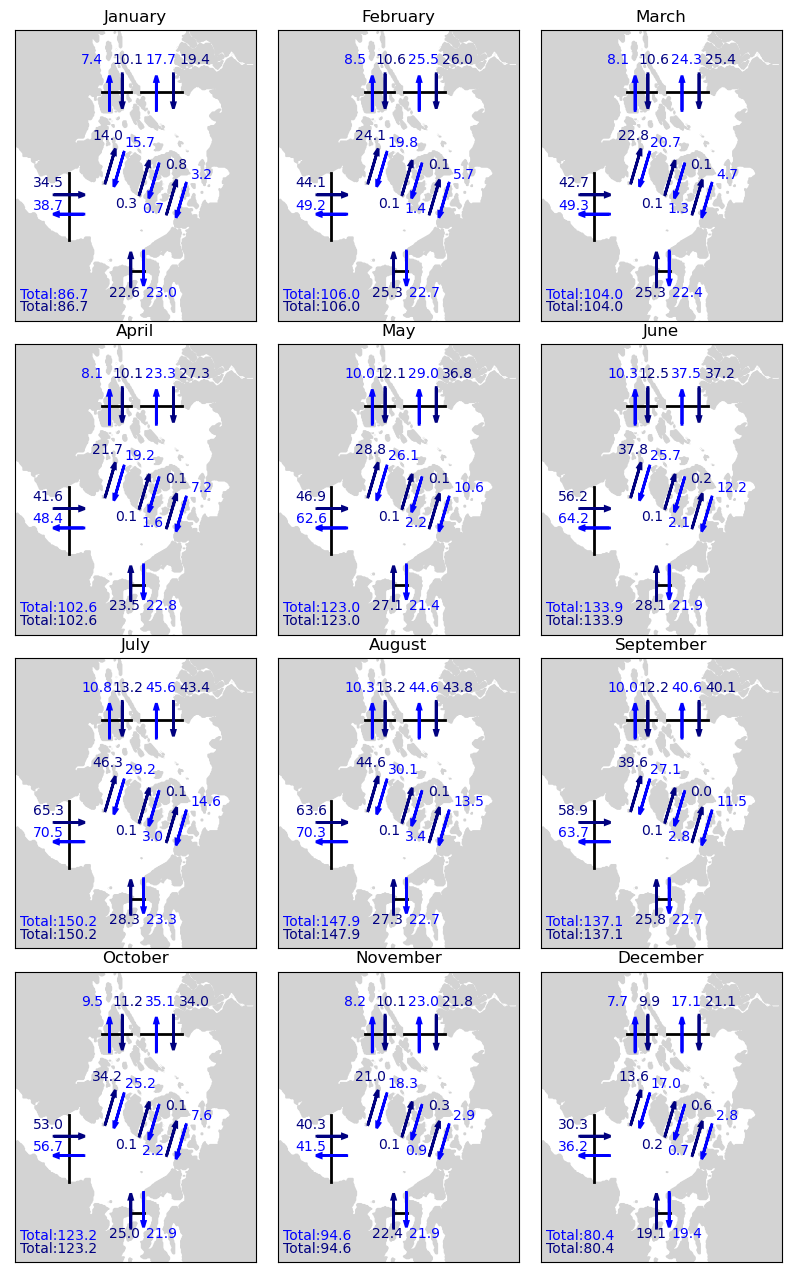

In [10]:
vs_y = np.arange(233,303,1)
vs_x = np.linspace(177,177,len(vs_y))
adm_x = np.arange(252,267,1)
adm_y = np.linspace(201,201,len(adm_x))
pr_x = np.arange(262,311,1)
pr_y = np.linspace(386,386,len(pr_x))
gulf_x = np.arange(216,251,1)
gulf_y = np.linspace(386,386,len(gulf_x))

months = ['January','February','March','April','May','June','July','August','September','October','November','December']
lw = 2

subdomain = [114, 397, 150, 450]
fig,[[ax1,ax2,ax3],[ax4,ax5,ax6],[ax7,ax8,ax9],[ax10,ax11,ax12]] = plt.subplots(4,3,figsize=(12, 16))

for ii,ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12]):
    for attr, color in zip(['contourf', 'contour'], ['lightgray', 'lightgrey']):
        getattr(ax, attr)(mesh.tmask[0, 0, ...],levels=[-0.01,0.01], colors=color) #If 0 -> contour f makes all that are 0 grey. contour makes the transition to 0 black

    ax.set_xlim(subdomain[:2])
    ax.set_ylim(subdomain[2:])
    # ax.set_xlabel('Grid X')
    # ax.set_ylabel('Grid Y')
    ax.set_xticks([])
    ax.set_yticks([])
    viz_tools.set_aspect(ax);

    ax.plot(vs_x,vs_y,color='k',lw=2)
    ax.plot(adm_x,adm_y,color='k',lw=2)
    ax.plot(pr_x,pr_y,color='k',lw=2)
    ax.plot(gulf_x,gulf_y,color='k',lw=2)

    #VicSill arrows
    ax.text(135, 288, '{:.1f}'.format(float(np.round(leave_vic[ii] / 1000, 1))),color='navy')
    ax.text(135, 265, '{:.1f}'.format(float(np.round(ent_vic[ii] / 1000, 1))),color='blue')
    ax.arrow(160, 280, 30, 0, head_width=4, edgecolor='navy', facecolor='navy', zorder=10,lw=lw)
    ax.arrow(195, 260, -30, 0, head_width=4, edgecolor='blue', facecolor='blue', zorder=10,lw=lw)

    #PointRob arrows
    ax.text(267, 415, '{:.1f}'.format(float(np.round(ent_pr[ii] / 1000, 1))),color='blue')
    ax.text(307, 415, '{:.1f}'.format(float(np.round(leave_pr[ii] / 1000, 1))),color='navy')
    ax.arrow(280, 367, 0, 30, head_width=4, edgecolor='blue', facecolor='blue', zorder=10,lw=lw)
    ax.arrow(300, 405, 0, -30, head_width=4, edgecolor='navy', facecolor='navy', zorder=10,lw=lw)

    #Gulf arrows
    ax.text(192, 415, '{:.1f}'.format(float(np.round(ent_gulf[ii] / 1000, 1))),color='blue')
    ax.text(229, 415, '{:.1f}'.format(float(np.round(leave_gulf[ii] / 1000, 1))),color='navy')
    ax.arrow(225, 367, 0, 30, head_width=4, edgecolor='blue', facecolor='blue', zorder=10,lw=lw)
    ax.arrow(240, 405, 0, -30, head_width=4, edgecolor='navy', facecolor='navy', zorder=10,lw=lw)

    #Adm arrows
    ax.text(225, 175, '{:.1f}'.format(float(np.round(leave_adm[ii] / 1000, 1))),color='navy')
    ax.text(268, 175, '{:.1f}'.format(float(np.round(ent_adm[ii] / 1000, 1))),color='blue')
    ax.arrow(250, 185, 0, 30, head_width=4, edgecolor='navy', facecolor='navy', zorder=10,lw=lw)
    ax.arrow(265, 222, 0, -30, head_width=4, edgecolor='blue', facecolor='blue', zorder=10,lw=lw)

    #Haro arrows
    ax.text(205, 337, '{:.1f}'.format(float(np.round(N_haro[ii] / 1000, 1))),color='navy')
    ax.text(243, 330, '{:.1f}'.format(float(np.round(S_haro[ii] / 1000, 1))),color='blue')
    ax.arrow(220, 292, 10, 30, head_width=4, edgecolor='navy', facecolor='navy', zorder=10,lw=lw)
    ax.arrow(242, 324, -10, -30, head_width=4, edgecolor='blue', facecolor='blue', zorder=10,lw=lw)

    # #SJC arrows
    ax.text(232, 267, '{:.1f}'.format(float(np.round(N_sjc[ii] / 1000, 1))),color='navy')
    ax.text(263, 261, '{:.1f}'.format(float(np.round(S_sjc[ii] / 1000, 1))),color='blue')
    ax.arrow(260, 280, 10, 30, head_width=4, edgecolor='navy', facecolor='navy', zorder=10,lw=lw)
    ax.arrow(283, 312, -10, -30, head_width=4, edgecolor='blue', facecolor='blue', zorder=10,lw=lw)

    # #Rosario arrows
    ax.text(290, 307, '{:.1f}'.format(float(np.round(N_ros[ii] / 1000, 1))),color='navy')
    ax.text(320, 297, '{:.1f}'.format(float(np.round(S_ros[ii] / 1000, 1))),color='blue')
    ax.arrow(292, 260, 10, 30, head_width=4, edgecolor='navy', facecolor='navy', zorder=10,lw=lw)
    ax.arrow(315, 292, -10, -30, head_width=4, edgecolor='blue', facecolor='blue', zorder=10,lw=lw)
    
    #Total
    ax.text(120, 160, 'Total:'+ '{:.1f}'.format(float(np.round(ent_total[ii] / 1000, 1))),color='navy')
    ax.text(120, 173, 'Total:'+ '{:.1f}'.format(float(np.round(leave_total[ii] / 1000, 1))),color='blue')
    
    ax.set_title(months[ii])

fig.subplots_adjust(hspace=0.08,wspace=-0.35)

In [11]:
fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/balances_supp.png',bbox_inches='tight')

/tmp/ipykernel_83385/484938498.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax[0].text(190, 288, '{:.1f}'.format(float(np.round(leave_vic[idx_1] / 1000, 1))),color='navy')
/tmp/ipykernel_83385/484938498.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax[0].text(190, 265, '{:.1f}'.format(float(np.round(ent_vic[idx_1] / 1000, 1))),color='blue')
/tmp/ipykernel_83385/484938498.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax[0].text(266, 415, '{:.1f

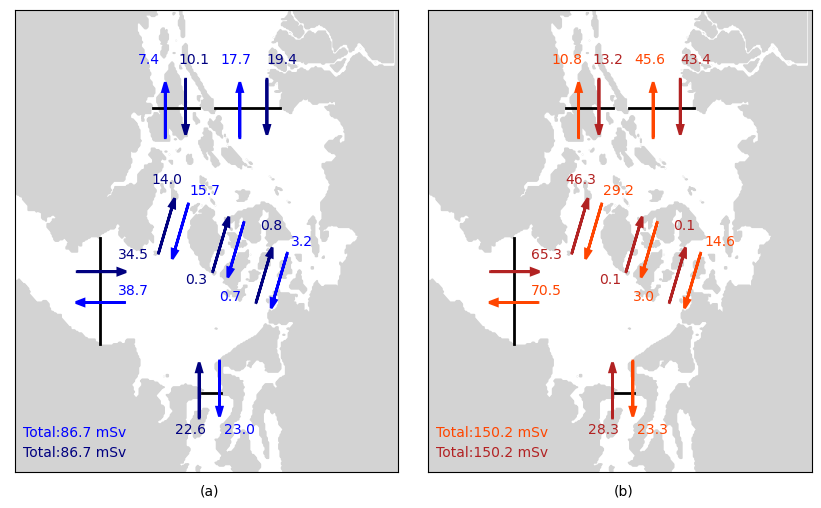

In [12]:
idx_1 = 0
idx_2 = 6

fig,ax = plt.subplots(1,2,figsize=(12, 6))

for attr, color in zip(['contourf', 'contour'], ['lightgray', 'lightgrey']):
    getattr(ax[0], attr)(mesh.tmask[0, 0, ...],levels=[-0.01,0.01], colors=color) #If 0 -> contour f makes all that are 0 grey. contour makes the transition to 0 black

ax[0].set_xlim(subdomain[:2])
ax[0].set_ylim(subdomain[2:])
# [0]ax.set_xlabel('Grid X')
# [0]ax.set_ylabel('Grid Y')
ax[0].set_xticks([])
ax[0].set_yticks([])
viz_tools.set_aspect(ax[0]);

ax[0].plot(vs_x,vs_y,color='k',lw=2)
ax[0].plot(adm_x,adm_y,color='k',lw=2)
ax[0].plot(pr_x,pr_y,color='k',lw=2)
ax[0].plot(gulf_x,gulf_y,color='k',lw=2)

#V[0]icSill arrows
ax[0].text(190, 288, '{:.1f}'.format(float(np.round(leave_vic[idx_1] / 1000, 1))),color='navy')
ax[0].text(190, 265, '{:.1f}'.format(float(np.round(ent_vic[idx_1] / 1000, 1))),color='blue')
ax[0].arrow(160, 280, 30, 0, head_width=4, edgecolor='navy', facecolor='navy', zorder=10,lw=lw)
ax[0].arrow(195, 260, -30, 0, head_width=4, edgecolor='blue', facecolor='blue', zorder=10,lw=lw)

#P[0]ointRob arrows
ax[0].text(266, 415, '{:.1f}'.format(float(np.round(ent_pr[idx_1] / 1000, 1))),color='blue')
ax[0].text(300, 415, '{:.1f}'.format(float(np.round(leave_pr[idx_1] / 1000, 1))),color='navy')
ax[0].arrow(280, 367, 0, 30, head_width=4, edgecolor='blue', facecolor='blue', zorder=10,lw=lw)
ax[0].arrow(300, 405, 0, -30, head_width=4, edgecolor='navy', facecolor='navy', zorder=10,lw=lw)

#G[0]ulf arrows
ax[0].text(205, 415, '{:.1f}'.format(float(np.round(ent_gulf[idx_1] / 1000, 1))),color='blue')
ax[0].text(235, 415, '{:.1f}'.format(float(np.round(leave_gulf[idx_1] / 1000, 1))),color='navy')
ax[0].arrow(225, 367, 0, 30, head_width=4, edgecolor='blue', facecolor='blue', zorder=10,lw=lw)
ax[0].arrow(240, 405, 0, -30, head_width=4, edgecolor='navy', facecolor='navy', zorder=10,lw=lw)

#A[0]dm arrows
ax[0].text(232, 175, '{:.1f}'.format(float(np.round(leave_adm[idx_1] / 1000, 1))),color='navy')
ax[0].text(268, 175, '{:.1f}'.format(float(np.round(ent_adm[idx_1] / 1000, 1))),color='blue')
ax[0].arrow(250, 185, 0, 30, head_width=4, edgecolor='navy', facecolor='navy', zorder=10,lw=lw)
ax[0].arrow(265, 222, 0, -30, head_width=4, edgecolor='blue', facecolor='blue', zorder=10,lw=lw)

#H[0]aro arrows
ax[0].text(215, 337, '{:.1f}'.format(float(np.round(N_haro[idx_1] / 1000, 1))),color='navy')
ax[0].text(243, 330, '{:.1f}'.format(float(np.round(S_haro[idx_1] / 1000, 1))),color='blue')
ax[0].arrow(220, 292, 10, 30, head_width=4, edgecolor='navy', facecolor='navy', zorder=10,lw=lw)
ax[0].arrow(242, 324, -10, -30, head_width=4, edgecolor='blue', facecolor='blue', zorder=10,lw=lw)

# [0]#SJC arrows
ax[0].text(240, 272, '{:.1f}'.format(float(np.round(N_sjc[idx_1] / 1000, 1))),color='navy')
ax[0].text(265, 261, '{:.1f}'.format(float(np.round(S_sjc[idx_1] / 1000, 1))),color='blue')
ax[0].arrow(260, 280, 10, 30, head_width=4, edgecolor='navy', facecolor='navy', zorder=10,lw=lw)
ax[0].arrow(283, 312, -10, -30, head_width=4, edgecolor='blue', facecolor='blue', zorder=10,lw=lw)

# [0]#Rosario arrows
ax[0].text(295, 307, '{:.1f}'.format(float(np.round(N_ros[idx_1] / 1000, 1))),color='navy')
ax[0].text(318, 297, '{:.1f}'.format(float(np.round(S_ros[idx_1] / 1000, 1))),color='blue')
ax[0].arrow(292, 260, 10, 30, head_width=4, edgecolor='navy', facecolor='navy', zorder=10,lw=lw)
ax[0].arrow(315, 292, -10, -30, head_width=4, edgecolor='blue', facecolor='blue', zorder=10,lw=lw)
    
#T[0]otal
ax[0].text(120, 160, 'Total:'+ '{:.1f}'.format(float(np.round(ent_total[idx_1] / 1000, 1))) + ' mSv',color='navy')
ax[0].text(120, 173, 'Total:'+ '{:.1f}'.format(float(np.round(leave_total[idx_1] / 1000, 1))) + ' mSv',color='blue')
    
# ax[0].set_title(months[idx_1])

color1 = 'firebrick'
color2 = 'orangered'

for attr, color in zip(['contourf', 'contour'], ['lightgray', 'lightgrey']):
    getattr(ax[1], attr)(mesh.tmask[0, 0, ...],levels=[-0.01,0.01], colors=color) #If 0 -> contour f makes all that are 0 grey. contour makes the transition to 0 black

ax[1].set_xlim(subdomain[:2])
ax[1].set_ylim(subdomain[2:])
# [0]ax.set_xlabel('Grid X')
# [0]ax.set_ylabel('Grid Y')
ax[1].set_xticks([])
ax[1].set_yticks([])
viz_tools.set_aspect(ax[1]);

ax[1].plot(vs_x,vs_y,color='k',lw=2)
ax[1].plot(adm_x,adm_y,color='k',lw=2)
ax[1].plot(pr_x,pr_y,color='k',lw=2)
ax[1].plot(gulf_x,gulf_y,color='k',lw=2)

#V[0]icSill arrows
ax[1].text(190, 288, '{:.1f}'.format(float(np.round(leave_vic[idx_2] / 1000, 1))),color=color1)
ax[1].text(190, 265, '{:.1f}'.format(float(np.round(ent_vic[idx_2] / 1000, 1))),color=color2)
ax[1].arrow(160, 280, 30, 0, head_width=4, edgecolor=color1, facecolor=color1, zorder=10,lw=lw)
ax[1].arrow(195, 260, -30, 0, head_width=4, edgecolor=color2, facecolor=color2, zorder=10,lw=lw)

#P[0]ointRob arrows
ax[1].text(266, 415, '{:.1f}'.format(float(np.round(ent_pr[idx_2] / 1000, 1))),color=color2)
ax[1].text(300, 415, '{:.1f}'.format(float(np.round(leave_pr[idx_2] / 1000, 1))),color=color1)
ax[1].arrow(280, 367, 0, 30, head_width=4, edgecolor=color2, facecolor=color2, zorder=10,lw=lw)
ax[1].arrow(300, 405, 0, -30, head_width=4, edgecolor=color1, facecolor=color1, zorder=10,lw=lw)

#G[0]ulf arrows
ax[1].text(205, 415, '{:.1f}'.format(float(np.round(ent_gulf[idx_2] / 1000, 1))),color=color2)
ax[1].text(235, 415, '{:.1f}'.format(float(np.round(leave_gulf[idx_2] / 1000, 1))),color=color1)
ax[1].arrow(225, 367, 0, 30, head_width=4, edgecolor=color2, facecolor=color2, zorder=10,lw=lw)
ax[1].arrow(240, 405, 0, -30, head_width=4, edgecolor=color1, facecolor=color1, zorder=10,lw=lw)

#A[0]dm arrows
ax[1].text(232, 175, '{:.1f}'.format(float(np.round(leave_adm[idx_2] / 1000, 1))),color=color1)
ax[1].text(268, 175, '{:.1f}'.format(float(np.round(ent_adm[idx_2] / 1000, 1))),color=color2)
ax[1].arrow(250, 185, 0, 30, head_width=4, edgecolor=color1, facecolor=color1, zorder=10,lw=lw)
ax[1].arrow(265, 222, 0, -30, head_width=4, edgecolor=color2, facecolor=color2, zorder=10,lw=lw)

#H[0]aro arrows
ax[1].text(215, 337, '{:.1f}'.format(float(np.round(N_haro[idx_2] / 1000, 1))),color=color1)
ax[1].text(243, 330, '{:.1f}'.format(float(np.round(S_haro[idx_2] / 1000, 1))),color=color2)
ax[1].arrow(220, 292, 10, 30, head_width=4, edgecolor=color1, facecolor=color1, zorder=10,lw=lw)
ax[1].arrow(242, 324, -10, -30, head_width=4, edgecolor=color2, facecolor=color2, zorder=10,lw=lw)

# [0]#SJC arrows
ax[1].text(240, 272, '{:.1f}'.format(float(np.round(N_sjc[idx_2] / 1000, 1))),color=color1)
ax[1].text(265, 261, '{:.1f}'.format(float(np.round(S_sjc[idx_2] / 1000, 1))),color=color2)
ax[1].arrow(260, 280, 10, 30, head_width=4, edgecolor=color1, facecolor=color1, zorder=10,lw=lw)
ax[1].arrow(283, 312, -10, -30, head_width=4, edgecolor=color2, facecolor=color2, zorder=10,lw=lw)

# [0]#Rosario arrows
ax[1].text(295, 307, '{:.1f}'.format(float(np.round(N_ros[idx_2] / 1000, 1))),color=color1)
ax[1].text(318, 297, '{:.1f}'.format(float(np.round(S_ros[idx_2] / 1000, 1))),color=color2)
ax[1].arrow(292, 260, 10, 30, head_width=4, edgecolor=color1, facecolor=color1, zorder=10,lw=lw)
ax[1].arrow(315, 292, -10, -30, head_width=4, edgecolor=color2, facecolor=color2, zorder=10,lw=lw)
    
#T[0]otal
ax[1].text(120, 160, 'Total:'+ '{:.1f}'.format(float(np.round(ent_total[idx_2] / 1000, 1))) + ' mSv',color=color1)
ax[1].text(120, 173, 'Total:'+ '{:.1f}'.format(float(np.round(leave_total[idx_2] / 1000, 1))) + ' mSv',color=color2)
    
# ax[1].set_title(months[idx_2])


fig.subplots_adjust(hspace=0.08,wspace=-0.2)
ax[0].text(0.483, -0.05, "(a)", transform=ax[0].transAxes)
ax[1].text(0.483, -0.05, "(b)", transform=ax[1].transAxes)

fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/full_balance.png',bbox_inches='tight')

#### Import split region data

In [13]:
## Split region

prtoharo = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/combined_from_ariane/prtoharo_final_transp.csv')
prtoros = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/combined_from_ariane/prtoros_final_transp.csv')
prtosjc = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/combined_from_ariane/prtosjc_final_transp.csv')

vstoharo = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/combined_from_ariane/vstoharo3_final_transp.csv')
vstoros = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/combined_from_ariane/vstoros3_final_transp.csv')
vstosjc = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/combined_from_ariane/vstosjc3_final_transp.csv')

admtoharo = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/combined_from_ariane/admtoharo3_finaltransp.csv')
admtoros = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/combined_from_ariane/admtoros3_finaltransp.csv')
admtosjc = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/combined_from_ariane/admtosjc3_finaltransp.csv')

## 31 days for split region
## 27 days for full region?


In [14]:
days_mon_split = [31,28,31,30,31,30,31,31,30,31,30,31]

prtoharo_avgtransp = np.sum(prtoharo)/days_mon_split/23
prtoros_avgtransp = np.sum(prtoros)/days_mon_split/23
prtosjc_avgtransp = np.sum(prtosjc)/days_mon_split/23

vstoharo_avgtransp = np.sum(vstoharo)/days_mon_split/23
vstoros_avgtransp = np.sum(vstoros)/days_mon_split/23
vstosjc_avgtransp = np.sum(vstosjc)/days_mon_split/23

admtoharo_avgtransp = np.sum(admtoharo)/days_mon_split/23
admtoros_avgtransp = np.sum(admtoros)/days_mon_split/23
admtosjc_avgtransp = np.sum(admtosjc)/days_mon_split/23

N2haro = vstoharo_avgtransp + admtoharo_avgtransp
N2ros = vstoros_avgtransp + admtoros_avgtransp
N2sjc = vstosjc_avgtransp + admtosjc_avgtransp

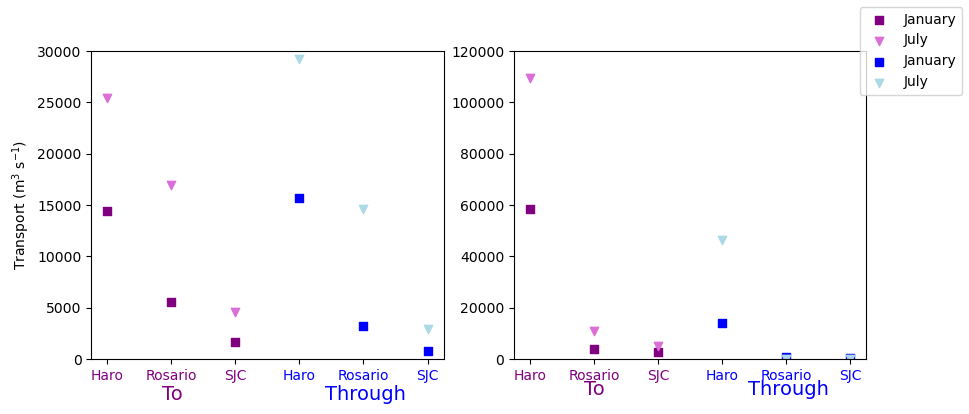

In [15]:
fig,[ax,ax2] = plt.subplots(1,2,figsize=(10,4))

ax.scatter([0,1,2],[prtoharo_avgtransp[0],prtoros_avgtransp[0],prtosjc_avgtransp[0]],label='January',color='purple',marker='s')
ax.scatter([0,1,2],[prtoharo_avgtransp[6],prtoros_avgtransp[6],prtosjc_avgtransp[6]],label='July',color='orchid',marker='v')
ax.scatter([3,4,5],[S_haro[0],S_ros[0],S_sjc[0]],label='January',color='blue',marker='s')
ax.scatter([3,4,5],[S_haro[6],S_ros[6],S_sjc[6]],label='July',color='lightblue',marker='v')

ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels(['Haro','Rosario','SJC','Haro','Rosario','SJC'],color='purple')
ax.set_ylim([0,30000])
red_xticks = [3, 4,5]
for i in red_xticks:
    ax.get_xticklabels()[i].set_color('blue')
    
ax.set_ylabel(r'Transport (m$^3$ s$^{-1}$)')
# ax.set_title('Transport from PointRob to VicSill')
ax.text(0.85,-4000,'To',fontsize=14,color='purple')
ax.text(3.4,-4000,'Through',fontsize=14,color='blue')

ax2.scatter([0,1,2],[N2haro[0],vstoros_avgtransp[0],vstosjc_avgtransp[0]],color='purple',marker='s')
ax2.scatter([0,1,2],[N2haro[6],vstoros_avgtransp[6],vstosjc_avgtransp[6]],color='orchid',marker='v')
ax2.scatter([3,4,5],[N_haro[0],N_ros[0],N_sjc[0]],color='blue',marker='s')
ax2.scatter([3,4,5],[N_haro[6],N_ros[6],N_sjc[6]],color='lightblue',marker='v')

ax2.set_xticks([0,1,2,3,4,5])
ax2.set_xticklabels(['Haro','Rosario','SJC','Haro','Rosario','SJC'],color='purple')

red_xticks = [3, 4,5]
for i in red_xticks:
    ax2.get_xticklabels()[i].set_color('blue')
    
ax2.text(0.85,-14000,'To',fontsize=14,color='purple')
ax2.text(3.4,-14000,'Through',fontsize=14,color='blue')
ax2.set_ylim([0,120000])
fig.legend();

#### Combine figures

/tmp/ipykernel_83385/4174859381.py:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax3.text(190, 288, '{:.1f}'.format(float(np.round(leave_vic[idx_1] / 1000, 1))),color='navy')
/tmp/ipykernel_83385/4174859381.py:67: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax3.text(190, 265, '{:.1f}'.format(float(np.round(ent_vic[idx_1] / 1000, 1))),color='blue')
/tmp/ipykernel_83385/4174859381.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax3.text(266, 415, '{:.1f}'.

Text(0.483, -0.06, '(d)')

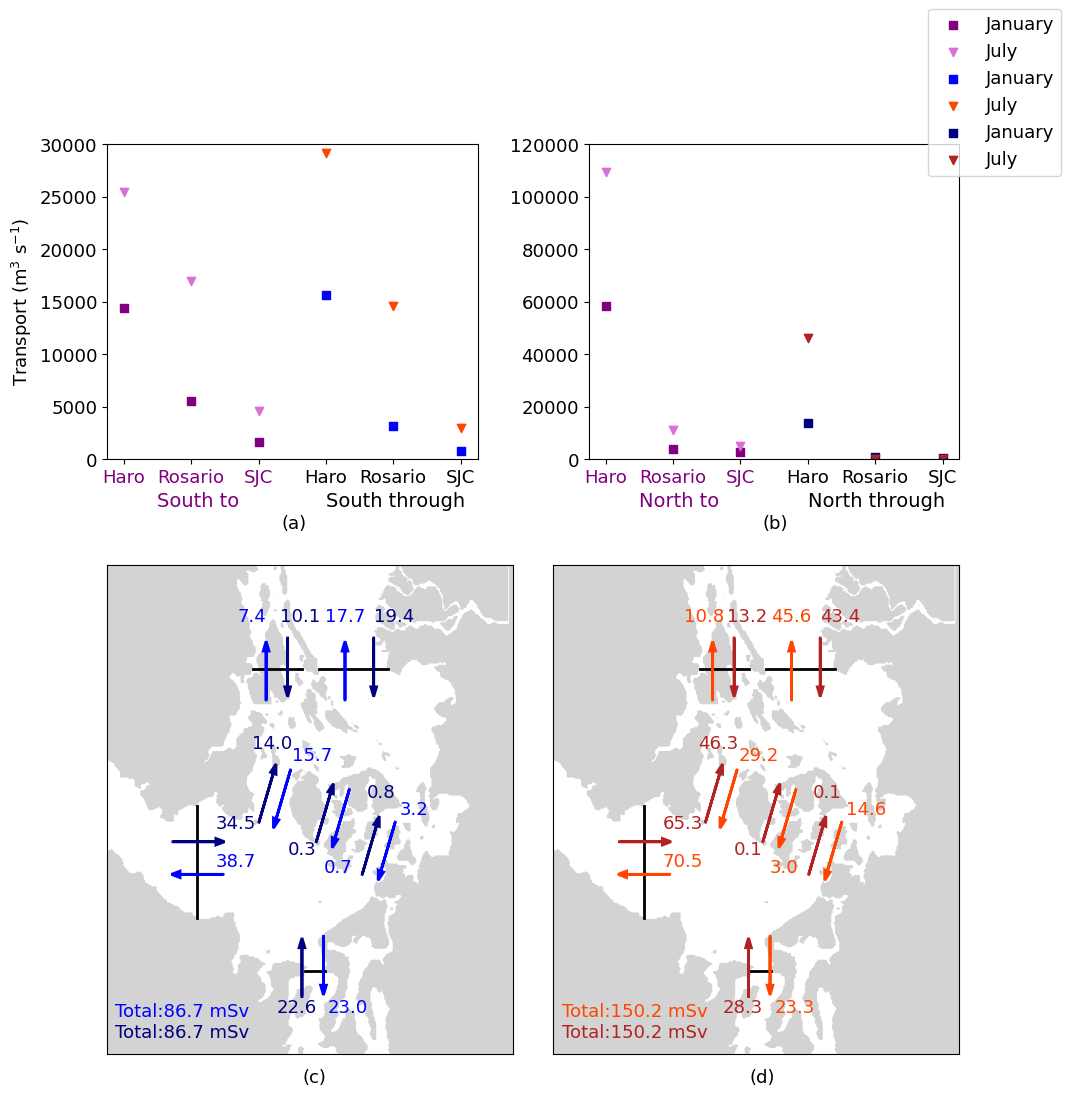

In [18]:
fig = plt.figure(figsize=(11,12))
plt.rcParams.update({'font.size': 13})

gs_parent = fig.add_gridspec(3, 1, height_ratios=[0.37,0.02, 0.61], hspace=0.13)
gs_top = gs_parent[0].subgridspec(1, 2,hspace=1,wspace=0.3)
gs_bottom = gs_parent[2].subgridspec(1, 2,hspace=0.2,wspace=0.1)

ax = fig.add_subplot(gs_top[0, 0])
ax2 = fig.add_subplot(gs_top[0, 1])
ax3 = fig.add_subplot(gs_bottom[0, 0])
ax4 = fig.add_subplot(gs_bottom[0, 1])

ax.scatter([0,1,2],[prtoharo_avgtransp[0],prtoros_avgtransp[0],prtosjc_avgtransp[0]],label='January',color='purple',marker='s')
ax.scatter([0,1,2],[prtoharo_avgtransp[6],prtoros_avgtransp[6],prtosjc_avgtransp[6]],label='July',color='orchid',marker='v')
ax.scatter([3,4,5],[S_haro[0],S_ros[0],S_sjc[0]],label='January',color='blue',marker='s')
ax.scatter([3,4,5],[S_haro[6],S_ros[6],S_sjc[6]],label='July',color='orangered',marker='v')

ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels(['Haro','Rosario','SJC','Haro','Rosario','SJC'],color='purple')
ax.set_ylim([0,30000])
red_xticks = [3, 4,5]
for i in red_xticks:
    ax.get_xticklabels()[i].set_color('k')
    
ax.set_ylabel(r'Transport (m$^3$ s$^{-1}$)')
# ax.set_title('Transport from PointRob to VicSill')
ax.text(0.5,-4500,'South to',fontsize=14,color='purple')
ax.text(3,-4500,'South through',fontsize=14,color='k')


ax2.scatter([3,4,5],[N_haro[0],N_ros[0],N_sjc[0]],label='January',color='navy',marker='s')
ax2.scatter([3,4,5],[N_haro[6],N_ros[6],N_sjc[6]],label='July',color='firebrick',marker='v')
fig.legend()
ax2.scatter([0,1,2],[N2haro[0],vstoros_avgtransp[0],vstosjc_avgtransp[0]],label='January',color='purple',marker='s')
ax2.scatter([0,1,2],[N2haro[6],vstoros_avgtransp[6],vstosjc_avgtransp[6]],label='July',color='orchid',marker='v')

ax2.set_xticks([0,1,2,3,4,5])
ax2.set_xticklabels(['Haro','Rosario','SJC','Haro','Rosario','SJC'],color='purple')

red_xticks = [3, 4,5]
for i in red_xticks:
    ax2.get_xticklabels()[i].set_color('k')
    
ax2.text(0.5,-18000,'North to',fontsize=14,color='purple')
ax2.text(3,-18000,'North through',fontsize=14,color='k')
ax2.set_ylim([0,120000])


for attr, color in zip(['contourf', 'contour'], ['lightgray', 'lightgrey']):
    getattr(ax3, attr)(mesh.tmask[0, 0, ...],levels=[-0.01,0.01], colors=color) #If 0 -> contour f makes all that are 0 grey. contour makes the transition to 0 black

ax3.set_xlim(subdomain[:2])
ax3.set_ylim(subdomain[2:])
# [0]ax.set_xlabel('Grid X')
# [0]ax.set_ylabel('Grid Y')
ax3.set_xticks([])
ax3.set_yticks([])
viz_tools.set_aspect(ax3);

ax3.plot(vs_x,vs_y,color='k',lw=2)
ax3.plot(adm_x,adm_y,color='k',lw=2)
ax3.plot(pr_x,pr_y,color='k',lw=2)
ax3.plot(gulf_x,gulf_y,color='k',lw=2)

#V[0]icSill arrows
ax3.text(190, 288, '{:.1f}'.format(float(np.round(leave_vic[idx_1] / 1000, 1))),color='navy')
ax3.text(190, 265, '{:.1f}'.format(float(np.round(ent_vic[idx_1] / 1000, 1))),color='blue')
ax3.arrow(160, 280, 30, 0, head_width=4, edgecolor='navy', facecolor='navy', zorder=10,lw=lw)
ax3.arrow(195, 260, -30, 0, head_width=4, edgecolor='blue', facecolor='blue', zorder=10,lw=lw)

#P[0]ointRob arrows
ax3.text(266, 415, '{:.1f}'.format(float(np.round(ent_pr[idx_1] / 1000, 1))),color='blue')
ax3.text(300, 415, '{:.1f}'.format(float(np.round(leave_pr[idx_1] / 1000, 1))),color='navy')
ax3.arrow(280, 367, 0, 30, head_width=4, edgecolor='blue', facecolor='blue', zorder=10,lw=lw)
ax3.arrow(300, 405, 0, -30, head_width=4, edgecolor='navy', facecolor='navy', zorder=10,lw=lw)

#G[0]ulf arrows
ax3.text(205, 415, '{:.1f}'.format(float(np.round(ent_gulf[idx_1] / 1000, 1))),color='blue')
ax3.text(235, 415, '{:.1f}'.format(float(np.round(leave_gulf[idx_1] / 1000, 1))),color='navy')
ax3.arrow(225, 367, 0, 30, head_width=4, edgecolor='blue', facecolor='blue', zorder=10,lw=lw)
ax3.arrow(240, 405, 0, -30, head_width=4, edgecolor='navy', facecolor='navy', zorder=10,lw=lw)

#A[0]dm arrows
ax3.text(232, 175, '{:.1f}'.format(float(np.round(leave_adm[idx_1] / 1000, 1))),color='navy')
ax3.text(268, 175, '{:.1f}'.format(float(np.round(ent_adm[idx_1] / 1000, 1))),color='blue')
ax3.arrow(250, 185, 0, 30, head_width=4, edgecolor='navy', facecolor='navy', zorder=10,lw=lw)
ax3.arrow(265, 222, 0, -30, head_width=4, edgecolor='blue', facecolor='blue', zorder=10,lw=lw)

#H[0]aro arrows
ax3.text(215, 337, '{:.1f}'.format(float(np.round(N_haro[idx_1] / 1000, 1))),color='navy')
ax3.text(243, 330, '{:.1f}'.format(float(np.round(S_haro[idx_1] / 1000, 1))),color='blue')
ax3.arrow(220, 292, 10, 30, head_width=4, edgecolor='navy', facecolor='navy', zorder=10,lw=lw)
ax3.arrow(242, 324, -10, -30, head_width=4, edgecolor='blue', facecolor='blue', zorder=10,lw=lw)

# [0]#SJC arrows
ax3.text(240, 272, '{:.1f}'.format(float(np.round(N_sjc[idx_1] / 1000, 1))),color='navy')
ax3.text(265, 261, '{:.1f}'.format(float(np.round(S_sjc[idx_1] / 1000, 1))),color='blue')
ax3.arrow(260, 280, 10, 30, head_width=4, edgecolor='navy', facecolor='navy', zorder=10,lw=lw)
ax3.arrow(283, 312, -10, -30, head_width=4, edgecolor='blue', facecolor='blue', zorder=10,lw=lw)

# [0]#Rosario arrows
ax3.text(295, 307, '{:.1f}'.format(float(np.round(N_ros[idx_1] / 1000, 1))),color='navy')
ax3.text(318, 297, '{:.1f}'.format(float(np.round(S_ros[idx_1] / 1000, 1))),color='blue')
ax3.arrow(292, 260, 10, 30, head_width=4, edgecolor='navy', facecolor='navy', zorder=10,lw=lw)
ax3.arrow(315, 292, -10, -30, head_width=4, edgecolor='blue', facecolor='blue', zorder=10,lw=lw)
    
#T[0]otal
ax3.text(120, 160, 'Total:'+ '{:.1f}'.format(float(np.round(ent_total[idx_1] / 1000, 1))) + ' mSv',color='navy')
ax3.text(120, 173, 'Total:'+ '{:.1f}'.format(float(np.round(leave_total[idx_1] / 1000, 1))) + ' mSv',color='blue')
    
# ax[0].set_title(months[idx_1])

color1 = 'firebrick'
color2 = 'orangered'

for attr, color in zip(['contourf', 'contour'], ['lightgray', 'lightgrey']):
    getattr(ax4, attr)(mesh.tmask[0, 0, ...],levels=[-0.01,0.01], colors=color) #If 0 -> contour f makes all that are 0 grey. contour makes the transition to 0 black

ax4.set_xlim(subdomain[:2])
ax4.set_ylim(subdomain[2:])
# [0]ax.set_xlabel('Grid X')
# [0]ax.set_ylabel('Grid Y')
ax4.set_xticks([])
ax4.set_yticks([])
viz_tools.set_aspect(ax4);

ax4.plot(vs_x,vs_y,color='k',lw=2)
ax4.plot(adm_x,adm_y,color='k',lw=2)
ax4.plot(pr_x,pr_y,color='k',lw=2)
ax4.plot(gulf_x,gulf_y,color='k',lw=2)

#V[0]icSill arrows
ax4.text(190, 288, '{:.1f}'.format(float(np.round(leave_vic[idx_2] / 1000, 1))),color=color1)
ax4.text(190, 265, '{:.1f}'.format(float(np.round(ent_vic[idx_2] / 1000, 1))),color=color2)
ax4.arrow(160, 280, 30, 0, head_width=4, edgecolor=color1, facecolor=color1, zorder=10,lw=lw)
ax4.arrow(195, 260, -30, 0, head_width=4, edgecolor=color2, facecolor=color2, zorder=10,lw=lw)

#P[0]ointRob arrows
ax4.text(266, 415, '{:.1f}'.format(float(np.round(ent_pr[idx_2] / 1000, 1))),color=color2)
ax4.text(300, 415, '{:.1f}'.format(float(np.round(leave_pr[idx_2] / 1000, 1))),color=color1)
ax4.arrow(280, 367, 0, 30, head_width=4, edgecolor=color2, facecolor=color2, zorder=10,lw=lw)
ax4.arrow(300, 405, 0, -30, head_width=4, edgecolor=color1, facecolor=color1, zorder=10,lw=lw)

#G[0]ulf arrows
ax4.text(205, 415, '{:.1f}'.format(float(np.round(ent_gulf[idx_2] / 1000, 1))),color=color2)
ax4.text(235, 415, '{:.1f}'.format(float(np.round(leave_gulf[idx_2] / 1000, 1))),color=color1)
ax4.arrow(225, 367, 0, 30, head_width=4, edgecolor=color2, facecolor=color2, zorder=10,lw=lw)
ax4.arrow(240, 405, 0, -30, head_width=4, edgecolor=color1, facecolor=color1, zorder=10,lw=lw)

#A[0]dm arrows
ax4.text(232, 175, '{:.1f}'.format(float(np.round(leave_adm[idx_2] / 1000, 1))),color=color1)
ax4.text(268, 175, '{:.1f}'.format(float(np.round(ent_adm[idx_2] / 1000, 1))),color=color2)
ax4.arrow(250, 185, 0, 30, head_width=4, edgecolor=color1, facecolor=color1, zorder=10,lw=lw)
ax4.arrow(265, 222, 0, -30, head_width=4, edgecolor=color2, facecolor=color2, zorder=10,lw=lw)

#H[0]aro arrows
ax4.text(215, 337, '{:.1f}'.format(float(np.round(N_haro[idx_2] / 1000, 1))),color=color1)
ax4.text(243, 330, '{:.1f}'.format(float(np.round(S_haro[idx_2] / 1000, 1))),color=color2)
ax4.arrow(220, 292, 10, 30, head_width=4, edgecolor=color1, facecolor=color1, zorder=10,lw=lw)
ax4.arrow(242, 324, -10, -30, head_width=4, edgecolor=color2, facecolor=color2, zorder=10,lw=lw)

# [0]#SJC arrows
ax4.text(240, 272, '{:.1f}'.format(float(np.round(N_sjc[idx_2] / 1000, 1))),color=color1)
ax4.text(265, 261, '{:.1f}'.format(float(np.round(S_sjc[idx_2] / 1000, 1))),color=color2)
ax4.arrow(260, 280, 10, 30, head_width=4, edgecolor=color1, facecolor=color1, zorder=10,lw=lw)
ax4.arrow(283, 312, -10, -30, head_width=4, edgecolor=color2, facecolor=color2, zorder=10,lw=lw)

# [0]#Rosario arrows
ax4.text(295, 307, '{:.1f}'.format(float(np.round(N_ros[idx_2] / 1000, 1))),color=color1)
ax4.text(318, 297, '{:.1f}'.format(float(np.round(S_ros[idx_2] / 1000, 1))),color=color2)
ax4.arrow(292, 260, 10, 30, head_width=4, edgecolor=color1, facecolor=color1, zorder=10,lw=lw)
ax4.arrow(315, 292, -10, -30, head_width=4, edgecolor=color2, facecolor=color2, zorder=10,lw=lw)
    
#T[0]otal
ax4.text(120, 160, 'Total:'+ '{:.1f}'.format(float(np.round(ent_total[idx_2] / 1000, 1))) + ' mSv',color=color1)
ax4.text(120, 173, 'Total:'+ '{:.1f}'.format(float(np.round(leave_total[idx_2] / 1000, 1))) + ' mSv',color=color2)
    
# ax[1].set_title(months[idx_2])

ax.text(0.47, -0.22, "(a)", transform=ax.transAxes,fontsize=13)
ax2.text(0.47, -0.22, "(b)", transform=ax2.transAxes,fontsize=13)
ax3.text(0.483, -0.06, "(c)", transform=ax3.transAxes,fontsize=13)
ax4.text(0.483, -0.06, "(d)", transform=ax4.transAxes,fontsize=13)

In [19]:
fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/tovsthru_wbalance.png',bbox_inches='tight')